    ==============================================================================================

## Importing the DataFrames
- ``` df = pd.read_pickle("file_name.pkl")```  --> create 1 df from a pkl file

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.min_rows", 0) 
pd.set_option("display.max_rows", 30) 
pd.__version__

'1.4.4'

In [127]:
db_qu = pd.read_pickle("clean_Tables\Merged_c.pkl")

In [128]:
db_qu.columns

Index(['ORD_ID', 'ord_CreatDate', 'ord_TotlPaid', 'OL_ID', 'ol_ProdQnty',
       'ol_ProdUntPr', 'ol_ProcessDate', 'PRO_SKU', 'pro_Name', 'pro_Desc',
       'pro_Pr', 'pro_InStock', 'pro_Type'],
      dtype='object')

    ==============================================================================================

## Answer Bussines questions


- Concerns
    A. The main investors pointed out the company’s recent quarterly results showed
        1.  increase in orders placed but a decrease in the total revenue. They prefer that the company positions itself in the quality segment, rather than competing to offer the lowest prices in the market.
    B. Questions
        1. How products should be classified into different categories to simplify reports and analysis.
        2. What is the distribution of product prices across different categories.
        3. How many products are being discounted.
        4. How big are the offered discounts as a percentage of the product prices. --> tmp_dis_per

### Discount Variation with Product Types


#### 4. How big are the offered discounts as a percentage of the product prices.

In [129]:
db_proDis=(
    db_qu
    #.drop(columns=drop_lst_proDis)
    #.reindex(columns=["PRO_SKU","pro_Name","pro_Type","ol_ProdUntPr","pro_Pr"])
    .assign(tmp_pro_dis = db_qu.pro_Pr - db_qu.ol_ProdUntPr)
)

In [130]:
db_proDis= (
    db_proDis
    .assign(tmp_dis_per = np.where((db_proDis.pro_Pr== 0.0)
                                   ,100
                                   ,round((db_proDis.tmp_pro_dis/db_proDis.pro_Pr)*100,2)
                                   ))
    )

In [131]:
# db_proDis.tmp_dis_per.means=''' amount of discount per product, 
# -ve means item sold higher than original price
# 0 means no discount
# 100 means item was sold for free '''

In [132]:
db_proDis.tmp_dis_per.describe()

count    60943.000000
mean        21.267464
std         18.752120
min       -212.270000
25%          8.330000
50%         17.270000
75%         28.290000
max        100.000000
Name: tmp_dis_per, dtype: float64

<AxesSubplot:>

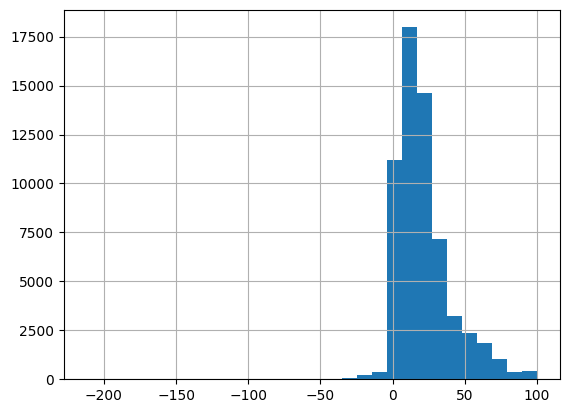

In [133]:
db_proDis.tmp_dis_per.hist(bins=30)

- Remove Outliers

In [134]:
Q1 = db_proDis.tmp_dis_per.quantile(0.25)
Q3 = db_proDis.tmp_dis_per.quantile(0.75)
IQR=Q3-Q1
inliers = (db_proDis.tmp_dis_per >= (Q1 - 1.5*IQR)) & (db_proDis.tmp_dis_per <= (Q3 + 1.5*IQR))
num_inliers = inliers.sum()
num_outliers = db_proDis.shape[0]-num_inliers 
per_outliers = round((num_outliers/db_proDis.shape[0])*100,2)
print(f'''{num_outliers} out of {db_proDis.shape[0]} are outliers from tmp_dis_per ,ie {per_outliers}%''') 

3857 out of 60943 are outliers from tmp_dis_per ,ie 6.33%


In [135]:
db_proDis = db_proDis.loc[inliers]

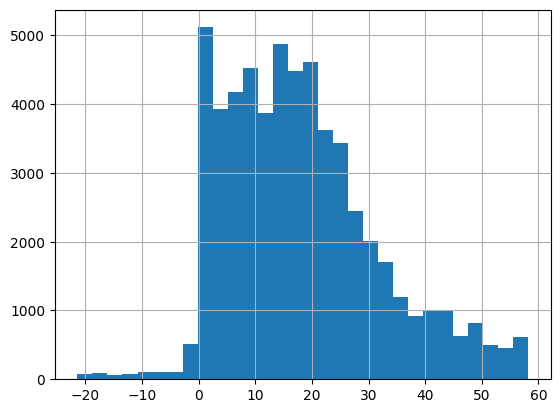

In [136]:
db_proDis.tmp_dis_per.hist(bins=30);

In [137]:
db_proDis.tmp_dis_per.describe()

count    57086.000000
mean        18.101614
std         13.647078
min        -21.410000
25%          7.720000
50%         16.420000
75%         25.590000
max         58.210000
Name: tmp_dis_per, dtype: float64

- Conclusion

In [138]:
print(f"The discounts grows up to {db_proDis.tmp_dis_per.max()}% of the product original price")

The discounts grows up to 58.21% of the product original price


Discounts over time

<AxesSubplot:xlabel='ord_CreatDate,ord_CreatDate'>

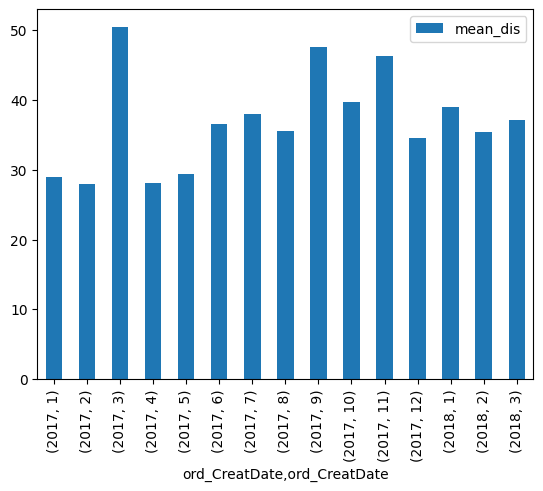

In [139]:
(
    db_proDis
    .groupby([db_proDis.ord_CreatDate.dt.year,db_proDis.ord_CreatDate.dt.month])
    .agg(mean_dis =("tmp_pro_dis","mean"))
    .plot(kind="bar")
    #.sort_values(by="mean_dis"
                 #,ascending=False
                # )
)

### B.1/2 product Categorization (db_proDis)
- Recap:
    - ol_ProdUntPr : the unitary price (euros) of each product at the moment of placing that order
    - pro_Pr       : product price without discounts
- check if rows are unique for sku
- discounts per product --> pro_Pr - ol_ProdUntPr

In [140]:
drop_list=["ORD_ID","ord_TotlPaid","ol_ProdQnty","ord_CreatDate","OL_ID","ol_ProcessDate","pro_InStock"]

In [141]:
#db_proCat = db_qu.drop(columns=drop_list)

##### Category via pro_Type

In [142]:
db_qu.pro_Type.nunique()

123

In [143]:
db_qu.shape

(60943, 13)

In [144]:
import re
def fix_type(row):
    val= row.pro_Type
    if "E" not in val:
        num_len= len(val)
        if num_len < 6:
            return [val,0]
        elif num_len == 8:
            return[val[4:8],val[0:4]]
        elif num_len == 9:
            return[val[5:9],val[0:5]]
    else:
        m = re.search('^(\d+),(\d+)E\+(\d{2})$', val)
        if m:
            return[m.group(1)+m.group(2),0]
        else:
            return[0,0]

In [145]:
db_qu[["tmp_type_1","tmp_type_2"]] = db_qu.apply(fix_type,axis=1,result_type="expand")

In [146]:
db_qu.sample(3)

,ORD_ID,ord_CreatDate,ord_TotlPaid,OL_ID,ol_ProdQnty,ol_ProdUntPr,ol_ProcessDate,PRO_SKU,pro_Name,pro_Desc,pro_Pr,pro_InStock,pro_Type,tmp_type_1,tmp_type_2
3481,399217,2017-09-12 15:57:20,35.97,1350794,2,15.99,2017-09-12 15:10:41,ALL0010,PowerCube Original USB Regleta Allocacoc wall White / Blue,Wall socket cube-shaped with 4 to 250V electrical outlets and 2 USB ports,18.95,True,5395,5395,0
36837,433546,2017-11-23 08:39:08,44.78,1425412,1,37.79,2017-11-23 08:29:34,APP1570,Apple Lightning to USB 3.0 Adapter,Lightning connector adapter to USB camera,45.00,True,5395,5395,0
49550,374082,2017-07-07 11:29:26,120.97,1285518,1,35.99,2017-07-07 10:40:10,PLA0014,Plantronics BackBeat GO 2 Bluetooth Headset Black,Wireless headphones with lightweight design Bluetooth connection and multifunction control for iPhone iPad and iPod,89.99,False,5384,5384,0


In [161]:

db_types=round(
    db_qu
    .groupby(db_qu.pro_Type)
    .agg( AvgUnitPrice      =("pro_Pr","mean")
         ,AvgDisUnitPrice   =("ol_ProdUntPr","mean")
         ,NumUniqProducts   =("PRO_SKU",pd.Series.nunique)
         ,NumUniqOrders     =("ORD_ID",pd.Series.nunique)
         ,TotalRevenue      =("ord_TotlPaid","sum")
         ,TotalSoldProdQnty =("ol_ProdQnty","sum")
         ,ProNameSample     =("pro_Name","max")
         ,ProDescSample     =("pro_Desc","max")
         )
    #.nlargest(10,"ol_ProdQnty")
    .reset_index()
)
db_types= (
    db_types
    .assign(AvgDiscoutPercent = np.where((db_types.AvgUnitPrice== 0.0)
                                   ,100
                                   ,round(((db_types.AvgUnitPrice-db_types.AvgDisUnitPrice)/db_types.AvgUnitPrice)*100,2)
                                   ))
    )


In [162]:
db_types.sample(3)

,pro_Type,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,ProNameSample,ProDescSample,AvgDiscoutPercent
2,"1,44E+11",111.0,79.0,27,101,11019.0,109,iPhone 5s battery repair,Repair service including parts and labor for iPhone 7 Plus,28.83
62,14305406,22.0,18.0,37,719,95964.0,832,iFixit rubber Kit for MacBook and MacBook Pro Unibody,small and thin spatula 15 for Mac mini and iPod Classic,18.18
106,5399,63.0,59.0,12,237,57558.0,269,iOttie One Touch Easy Qi Wireless Charger iPhone Support X / 8 Plus / 8,Wireless charging base Ryval magnetic and Qi technology ideal for iPhone X / 8Plus / 8 at home and in the office,6.35


In [ ]:
#db_types.to_csv("test.csv")

In [148]:
round(db_types.describe())

,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,AvgDiscoutPercent
count,123.0,123.0,123.0,123.0,123.0,123.0,123.0
mean,494.0,413.0,48.0,469.0,198368.0,556.0,22.0
std,852.0,769.0,91.0,745.0,343346.0,923.0,17.0
min,6.0,5.0,1.0,1.0,97.0,1.0,-4.0
25%,59.0,41.0,5.0,32.0,9466.0,36.0,10.0
50%,151.0,112.0,20.0,169.0,47478.0,171.0,19.0
75%,542.0,444.0,42.0,657.0,225197.0,706.0,28.0
max,5554.0,5221.0,714.0,4092.0,2050209.0,4848.0,90.0


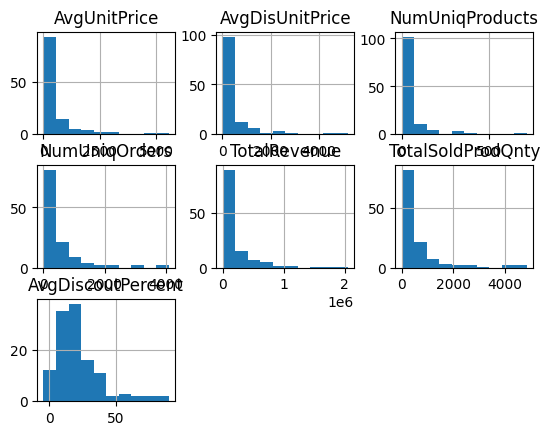

In [149]:
db_types.hist();

- Get Top 10s

In [150]:
db_types.sample(3)

,tmp_type_1,tmp_type_2,AvgUnitPrice,AvgDisUnitPrice,NumUniqProducts,NumUniqOrders,TotalRevenue,TotalSoldProdQnty,ProNameSample,ProDescSample,AvgDiscoutPercent
17,1364,0,145.0,110.0,180,3243,753618.0,4088,Open - SO-DIMM memory Kingston 4GB 1600Mhz DDR3åÊ,modules RAM 64GB (4x16GB) Mac Pro (2009-2010).,24.14
21,1404,0,134.0,124.0,17,63,26584.0,72,Synology Rail Kit sliding RKS1314,expansion module for Nas eSATA and 5 bays,7.46
30,1714,0,469.0,446.0,20,274,186859.0,306,Open - Apple iPad Wi-Fi 32GB Space Gray,iPad Wi-Fi 32GB with box but unused is perfect,4.90


In [154]:
(
    db_types
    .query("AvgUnitPrice.nlargest(10)")
)

KeyError: "None of [Float64Index([5554.0, 4771.0, 3215.0, 2806.0, 2558.0, 2479.0, 2022.0, 1759.0,\n              1752.0, 1671.0],\n             dtype='float64')] are in the [index]"

In [ ]:
# g=sns.relplot(data=db_types
#             ,x="AvgUnitPrice"
#             ,y= "AvgDiscoutPercent"
#             )
sns.relplot(data=db_types
            ,kind="line"
            ,x="AvgDiscoutPercent"
            ,y="TotalRevenue"
            #,hue="TotalSoldProdQnty"
            #,style="event",
)


In [ ]:
pd.set_option("display.max_colwidth", 5000) 
db_types.sample(3)

##### Category via pro_Name

In [ ]:
db_proDis.pro_Name.sample(10)

In [157]:
from collections import Counter
from stop_words import get_stop_words
import nltk
from nltk import corpus

nltk.download('stopwords')
stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(corpus.stopwords.words('english')) #About 150 stopwords
other_words = [" ",",","?","|","/","-"]
stop_words.extend(nltk_words)
stop_words.extend(other_words)
#print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jacqueline\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:

def common_words(row):
    text=row.pro_Name
    split_it = text.split()
    filtered_words = [w for w in split_it if not w in stop_words]
    #print(filtered_words)
    counter = Counter(filtered_words)
    most_occur = counter.most_common(5)
    return(most_occur)

#common_words("Hi baby iam here , where are you ?")

In [ ]:
db_types.loc[2]

In [160]:
db_qu.
apply(common_words,axis=1)

0                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
1                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
2                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
3                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
4                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
5                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
6                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
7                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
8                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
9                 [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
10                [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Desktop, 1)]
11                [(Drive, 2), (LaCie, 1), (Porsche, 1), (Design, 1), (Deskt

In [ ]:
db_types.cat_1.to_csv("test.csv")

In [ ]:
db_types.groupby(db_types.tmp_type_1).describe().pro_Pr.sort_values(by="mean")

__ Category via pro_Pr

In [ ]:
db_qu.pro_Pr.describe()

In [ ]:
def Price_cat (price):
    if price < 50:
        return "A"
    elif price < 200:
        return "B"
    elif price < 1000:
        return "C"
    elif price < 5000:
        return "D"
    elif price >= 5000:
        return "E"


In [ ]:
db_proDis["tmp_pr_cat"] = db_proDis.pro_Pr.map(Price_cat)

In [ ]:
(
    db_proDis
    .groupby("tmp_pr_cat")
    .agg(price_cat_num=("tmp_pr_cat","count"))
)

In [ ]:
pd.set_option('max_colwidth', 100)

In [ ]:
db_proDis.loc[db_proDis.tmp_pr_cat == "A"].drop(columns=drop_list).sample(5)

In [ ]:
db_proDis.loc[db_proDis.pro_Name.str.contains("(imac)", case=False, regex=True)].drop(columns=drop_list)

In [ ]:
pattern = '|'.join(["watch"])

In [ ]:
pattern = '|'.join(["watch"])
db_proDis.loc[db_proDis.pro_Name.str.contains(pattern, case=False, regex=True)].drop(columns=drop_list).sample(10)

In [ ]:
db_proDis.sample(5)